# Modeling and Evaluation Notebook

In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200615180825-0000
KERNEL_ID = de672643-275a-440b-bd8d-b5ffae39ee14


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Change the column names to be more representative for the data for enviornmental conditions.

In [2]:
#Renamce the column names
df.rename(columns={'AT': 'AtmTemperature', 'V': 'ExhaustV', 'AP': 'AtmPressure', 'RH': 'RelHumidity', 'PE': 'PowerOut'}, inplace=True)
df.head()

,AtmTemperature,ExhaustV,AtmPressure,RelHumidity,PowerOut
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Remove the "NaN" or non-existent values colums. First check the number of "NaN" values in each column in the dataset

In [3]:
print("Number of NaN values for the column temperature :", df['AtmTemperature'].isnull().sum())
print("Number of NaN values for the column exhaust_vacuum :", df['ExhaustV'].isnull().sum())
print("Number of NaN values for the column ambient_pressure :", df['AtmPressure'].isnull().sum())
print("Number of NaN values for the column relative_humidity :", df['RelHumidity'].isnull().sum())
print("Number of NaN values for the column energy_output :", df['PowerOut'].isnull().sum())

Number of NaN values for the column temperature : 0
Number of NaN values for the column exhaust_vacuum : 0
Number of NaN values for the column ambient_pressure : 0
Number of NaN values for the column relative_humidity : 0
Number of NaN values for the column energy_output : 0


Since total number of "NaN" values is zero in each column, the removal of non-existent values is not required.
Now, split the data frame to train and test data frames.

In [3]:
#Use IQR score method to remove outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

AtmTemperature    12.2100
ExhaustV          24.8000
AtmPressure        8.1600
RelHumidity       21.5025
PowerOut          28.6800
dtype: float64


In [4]:
#Use IQR score method to remove outliers
df2 = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df2.shape

(9468, 5)

In [5]:
#Split data into test and train
from sklearn.model_selection import train_test_split

train, test = train_test_split(df2, test_size=0.2)

In [7]:
train.head()

,AtmTemperature,ExhaustV,AtmPressure,RelHumidity,PowerOut
6904,10.12,40.00,1021.33,95.29,476.03
5230,27.40,69.84,1002.98,76.48,430.54
4842,10.74,40.92,1021.74,94.97,466.77
8997,27.83,72.29,1012.04,48.86,445.73
1168,15.44,39.54,1007.49,82.14,469.28


In [8]:
test.head()

,AtmTemperature,ExhaustV,AtmPressure,RelHumidity,PowerOut
1688,14.33,38.73,1003.52,85.92,468.86
7071,21.98,59.39,1015.25,84.52,446.79
793,16.42,40.56,1020.36,50.62,472.17
3405,11.23,43.67,1012.57,72.10,475.41
1509,25.21,65.34,1013.94,65.04,446.68


Now, load test and train data to Spark for data modeling and evaluation

In [6]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [7]:
trainspark_df = sqlContext.createDataFrame(train)
testspark_df = sqlContext.createDataFrame(test)

In [11]:
trainspark_df.show(5)

+--------------+--------+-----------+-----------+--------+
|AtmTemperature|ExhaustV|AtmPressure|RelHumidity|PowerOut|
+--------------+--------+-----------+-----------+--------+
|         12.38|    40.6|    1013.86|      85.35|  472.53|
|         27.71|   66.93|    1016.85|      58.77|  447.06|
|         18.61|   47.83|    1006.43|      78.89|  454.21|
|         18.58|   63.78|    1016.24|      78.74|  453.96|
|         23.07|   65.46|    1014.07|      46.77|  446.19|
+--------------+--------+-----------+-----------+--------+
only showing top 5 rows



In [8]:
testspark_df.show(5)

+--------------+--------+-----------+-----------+--------+
|AtmTemperature|ExhaustV|AtmPressure|RelHumidity|PowerOut|
+--------------+--------+-----------+-----------+--------+
|         23.28|   68.28|    1000.79|      81.35|  442.04|
|          3.38|   41.31|     998.79|      97.76|  489.11|
|         14.59|   35.71|    1015.19|      54.13|  469.32|
|         25.32|   48.41|    1008.47|      72.14|  443.04|
|          8.02|   39.04|    1018.49|      68.07|  479.53|
+--------------+--------+-----------+-----------+--------+
only showing top 5 rows



In [12]:
print("Number of records in training data set ")
trainspark_df.count()

Number of records in training data set 


7574

In [13]:
print("Number of records in test data set ")
testspark_df.count()

Number of records in test data set 


1894

# Regression Models

# Linear Regression

## a) Creating Pipelines

In [8]:
# Create input features and forecast column 
from pyspark.ml.feature import VectorAssembler

vectorizer = VectorAssembler()
vectorizer3 = VectorAssembler()
vectorizer2 = VectorAssembler()
# all 4 parameters as input features
vectorizer.setInputCols(["AtmTemperature", "ExhaustV", "AtmPressure", "RelHumidity"])
#  3 parameters as input features
vectorizer3.setInputCols(["AtmTemperature", "ExhaustV", "AtmPressure"])
# 2 parameters as input features
vectorizer2.setInputCols(["AtmTemperature", "ExhaustV"])
vectorizer.setOutputCol("features")
vectorizer3.setOutputCol("features")
vectorizer2.setOutputCol("features")


VectorAssembler_45202cc684ec

In [9]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# Initialize linear regression models
lr = LinearRegression()

# Setting the parameters for the method
lr.setPredictionCol("Forecast_PowerOut")\
  .setLabelCol("PowerOut")\
  .setFeaturesCol("features")\
  .setMaxIter(100)\
  .setRegParam(0.1)\
  .setElasticNetParam=0.8
    
lrPipeline = Pipeline()
lrPipeline3 = Pipeline()
lrPipeline2 = Pipeline()
lrPipeline.setStages([vectorizer, lr])
lrPipeline3.setStages([vectorizer3, lr])
lrPipeline2.setStages([vectorizer2, lr])

Pipeline_1acf3a863ab8

In [10]:
# Training the model for 4 input features
lrModel = lrPipeline.fit(trainspark_df)

In [12]:
# Training the model for 3 input features
lrModel3 = lrPipeline3.fit(trainspark_df)

In [13]:
# Training the model for 2 input features
lrModel2 = lrPipeline2.fit(trainspark_df)

## Final Deliverable
Now, linear regression equation will be prepared from the model which is one of the deliverables for the clients. The second deliverable is the project report.

In [11]:
# Creating equation for 4 input features 
# The intercept of the equation
intercept = lrModel.stages[1].intercept

# The coefficents or weights
weights = lrModel.stages[1].coefficients

# List of the column names (without Forecast_Powerout)
inputFeatures = [col for col in df.columns if col != "Forecast_PowerOut"]

# Merging the weights and column names for the equation
coefficents = sorted(zip(weights, inputFeatures), key=lambda tup: abs(tup[0]), reverse=True)
#Printing the equation
equation = "Forecasted Plant Power Output = {intercept}".format(intercept=intercept)
variables = []
for x in coefficents:
    weight = abs(x[0])
    name = x[1]
    symbol = "+" if (x[0] > 0) else "-"
    equation += (" {} ({} * {})".format(symbol, weight, name))

# Here is our equation
print("Linear Regression Equation: " + equation)

Linear Regression Equation: Forecasted Plant Power Output = 423.7083697584103 - (1.9181561274729453 * AtmTemperature) - (0.2577430738972399 * ExhaustV) - (0.15110450688813545 * RelHumidity) + (0.09225648248956152 * AtmPressure)


In [14]:
# Creating equation for 3 input features 
# The intercept of the equation
intercept3 = lrModel3.stages[1].intercept

# The coefficents or weights
weights3 = lrModel3.stages[1].coefficients

# List of the column names (without Forecast_Powerout)
inputFeatures3 = [col for col in df.columns if (col != "Forecast_PowerOut")]

# Merging the weights and column names for the equation
coefficents = sorted(zip(weights3, inputFeatures3), key=lambda tup: abs(tup[0]), reverse=True)
#Printing the equation
equation = "Forecasted Plant Power Output = {intercept3}".format(intercept3=intercept3)
variables = []
for x in coefficents:
    weight = abs(x[0])
    name = x[1]
    symbol = "+" if (x[0] > 0) else "-"
    equation += (" {} ({} * {})".format(symbol, weight, name))

# Here is our equation
print("Linear Regression Equation with 3 input features: " + equation)

Linear Regression Equation with 3 input features: Forecasted Plant Power Output = 317.5365573384401 - (1.6063455039832601 * AtmTemperature) - (0.33751520723775746 * ExhaustV) + (0.18428639421326445 * AtmPressure)


In [15]:
# Creating equation for 2 input features 
# The intercept of the equation
intercept2 = lrModel2.stages[1].intercept

# The coefficents or weights
weights2 = lrModel2.stages[1].coefficients

# List of the column names (without Forecast_Powerout)
inputFeatures2 = [col for col in df.columns if (col != "Forecast_PowerOut")]

# Merging the weights and column names for the equation
coefficents = sorted(zip(weights2, inputFeatures2), key=lambda tup: abs(tup[0]), reverse=True)
#Printing the equation
equation = "Forecasted Plant Power Output = {intercept2}".format(intercept2=intercept2)
variables = []
for x in coefficents:
    weight = abs(x[0])
    name = x[1]
    symbol = "+" if (x[0] > 0) else "-"
    equation += (" {} ({} * {})".format(symbol, weight, name))

# Here is our equation
print("Linear Regression Equation with 2 input features: " + equation)

Linear Regression Equation with 2 input features: Forecasted Plant Power Output = 505.59501307414996 - (1.6809053221401071 * AtmTemperature) - (0.33522089449197023 * ExhaustV)


Testing the model with test datasets for 4, 3 and 2 input features

In [12]:
# Testing the model for dataset with 4 input variables as features
dfTest = lrModel.transform(testspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "RelHumidity", "PowerOut", "Forecast_PowerOut")

In [15]:
# Testing the model for dataset with 3 input variables as features
dfTest3 = lrModel3.transform(testspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "PowerOut", "Forecast_PowerOut")

In [16]:
# Testing the model for dataset with 2 input variables as features
dfTest2 = lrModel2.transform(testspark_df).select("AtmTemperature", "ExhaustV", "PowerOut", "Forecast_PowerOut")

In [13]:
# computing evaluation metric for our test and traing datasets for 4 input features
from pyspark.ml.evaluation import RegressionEvaluator
trainingSummary = lrModel.stages[-1].summary

print("r2 for training data set: %f" % trainingSummary.r2)
# Creating an r2 evaluator by using the label column and forecast column
regEval = RegressionEvaluator(predictionCol="Forecast_PowerOut", labelCol="PowerOut")
r2Test = regEval.evaluate(dfTest, {regEval.metricName: "r2"})
print("r2 for testing data set: {:.6f}".format(r2Test))

r2 for training data set: 0.928115
r2 for testing data set: 0.927421


In [20]:
# computing evaluation metric for our test and traing datasets for 3 input features
from pyspark.ml.evaluation import RegressionEvaluator
trainingSummary3 = lrModel3.stages[-1].summary

print("r2 for training data set with 3 input features: %f" % trainingSummary3.r2)
# Creating an r2 evaluator by using the label column and forecast column
regEval = RegressionEvaluator(predictionCol="Forecast_PowerOut", labelCol="PowerOut")
r2Test3 = regEval.evaluate(dfTest3, {regEval.metricName: "r2"})
print("r2 for testing data set with 3 input features: {:.6f}".format(r2Test3))

r2 for training data set with 3 input features: 0.917527
r2 for testing data set with 3 input features: 0.915926


In [21]:
# computing evaluation metric for our test and traing datasets for 2 input features
trainingSummary2 = lrModel2.stages[-1].summary

print("r2 for training data set with 2 input features: %f" % trainingSummary2.r2)
# Creating an r2 evaluator by using the label column and forecast column
regEval = RegressionEvaluator(predictionCol="Forecast_PowerOut", labelCol="PowerOut")
r2Test2 = regEval.evaluate(dfTest2, {regEval.metricName: "r2"})
print("r2 for testing data set with 2 input features: {:.6f}".format(r2Test2))

r2 for training data set with 2 input features: 0.914916
r2 for testing data set with 2 input features: 0.914262


## Hyperparameter Tuning
### Cross Validation and Grid Search

In [31]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import numpy as np

# Cross validating with 4 fold cross validation for 4, 3 and 2 input features
crossval = CrossValidator(estimator=lrPipeline, evaluator=regEval, numFolds=4)
crossval3 = CrossValidator(estimator=lrPipeline3, evaluator=regEval, numFolds=4)
crossval2 = CrossValidator(estimator=lrPipeline2, evaluator=regEval, numFolds=4)

# Creating the paramter grid using the ParamGridBuilder, and adding the grid to the CrossValidator for 4, 3 and 2 input features
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, np.linspace(0.01, 0.1, 10))
             .build())
crossval.setEstimatorParamMaps(paramGrid)
crossval3.setEstimatorParamMaps(paramGrid)
crossval2.setEstimatorParamMaps(paramGrid)

# Finding and returning the best model for 4, 3 and 2 input features
cvModel = crossval.fit(trainspark_df).bestModel
cvModel3 = crossval3.fit(trainspark_df).bestModel
cvModel2 = crossval2.fit(trainspark_df).bestModel

In [32]:
# compute an evaluation metric for our test and training datasets for cv modeling for 4, 3 and 2 input features
dfTest1 = cvModel.transform(testspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "RelHumidity", "PowerOut", "Forecast_PowerOut")
dfTrain1 = cvModel.transform(trainspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "RelHumidity", "PowerOut", "Forecast_PowerOut")
dfTest13 = cvModel3.transform(testspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "PowerOut", "Forecast_PowerOut")
dfTrain13 = cvModel3.transform(trainspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "PowerOut", "Forecast_PowerOut")
dfTest12 = cvModel2.transform(testspark_df).select("AtmTemperature", "ExhaustV", "PowerOut", "Forecast_PowerOut")
dfTrain12 = cvModel2.transform(trainspark_df).select("AtmTemperature", "ExhaustV", "PowerOut", "Forecast_PowerOut")
# Computing the r2 evaluation metric for test dataset for 4, 3 and 2 input features
r2CVTest = regEval.evaluate(dfTest1, {regEval.metricName: "r2"})
r2CVTrain = regEval.evaluate(dfTrain1, {regEval.metricName: "r2"})
r2CVTest3 = regEval.evaluate(dfTest13, {regEval.metricName: "r2"})
r2CVTrain3 = regEval.evaluate(dfTrain13, {regEval.metricName: "r2"})
r2CVTest2 = regEval.evaluate(dfTest12, {regEval.metricName: "r2"})
r2CVTrain2 = regEval.evaluate(dfTrain12, {regEval.metricName: "r2"})
print("New r2Train after hyperparameter tuning: {0:2.6f}".format(r2CVTrain))
print("New r2Test after hyperparameter tuning: {0:2.6f}".format(r2CVTest))
print("New r2Train after hyperparameter tuning with 3 input features: {0:2.6f}".format(r2CVTrain3))
print("New r2Test after hyperparameter tuning with 3 input features: {0:2.6f}".format(r2CVTest3))
print("New r2Train after hyperparameter tuning with 2 input features: {0:2.6f}".format(r2CVTrain2))
print("New r2Test after hyperparameter tuning with 2 input features: {0:2.6f}".format(r2CVTest2))

New r2Train after hyperparameter tuning: 0.929045
New r2Test after hyperparameter tuning: 0.924234
New r2Train after hyperparameter tuning with 3 input features: 0.918585
New r2Test after hyperparameter tuning with 3 input features: 0.911898
New r2Train after hyperparameter tuning with 2 input features: 0.916268
New r2Test after hyperparameter tuning with 2 input features: 0.909032


In [31]:
# Creating equation for 4 input features

# The intercept of the equation 
intercept = cvModel.stages[1].intercept

# The coefficents or weights
weights = cvModel.stages[1].coefficients

# List of the column names (without Forecast_Powerout)
inputFeatures = [col for col in df.columns if col != "Forecast_PowerOut"]

# Merging the weights and column names for the equation
coefficents = sorted(zip(weights, inputFeatures), key=lambda tup: abs(tup[0]), reverse=True)
#Printing the equation
equation = "Forecasted Plant Power Output = {intercept}".format(intercept=intercept)
variables = []
for x in coefficents:
    weight = abs(x[0])
    name = x[1]
    symbol = "+" if (x[0] > 0) else "-"
    equation += (" {} ({} * {})".format(symbol, weight, name))

# Here is our equation
print("Linear Regression Equation: " + equation)

Linear Regression Equation: Forecasted Plant Power Output = 446.1924923349714 - (1.9680421282770566 * AtmTemperature) - (0.2364044172588626 * ExhaustV) - (0.1577796104210562 * RelHumidity) + (0.07031610378372735 * AtmPressure)


In [74]:
# Creating equation for 3 input features
# The intercept of the equation
intercept3 = cvModel3.stages[1].intercept

# The coefficents or weights
weights3 = cvModel3.stages[1].coefficients

# List of the column names (without Forecast_Powerout)
inputFeatures3 = [col for col in df.columns if col != "Forecast_PowerOut"]

# Merging the weights and column names for the equation
coefficents3 = sorted(zip(weights3, inputFeatures3), key=lambda tup: abs(tup[0]), reverse=True)
#Printing the equation
equation = "Forecasted Plant Power Output for 3 input features = {intercept3}".format(intercept3=intercept3)
variables = []
for x in coefficents3:
    weight = abs(x[0])
    name = x[1]
    symbol = "+" if (x[0] > 0) else "-"
    equation += (" {} ({} * {})".format(symbol, weight, name))

# Here is our equation
print("Linear Regression Equation: for 3 input features " + equation)

Linear Regression Equation: for 3 input features Forecasted Plant Power Output for 3 input features = 329.72488277651905 - (1.6356082276770958 * AtmTemperature) - (0.3218691399475828 * ExhaustV) + (0.17198125834974187 * AtmPressure)


In [75]:
# Creating equation for 3 input features

# The intercept of the equation
intercept2 = cvModel2.stages[1].intercept

# The coefficents or weights
weights2 = cvModel2.stages[1].coefficients

# List of the column names (without Forecast_Powerout)
inputFeatures2 = [col for col in df.columns if col != "Forecast_PowerOut"]

# Merging the weights and column names for the equation
coefficents2 = sorted(zip(weights2, inputFeatures2), key=lambda tup: abs(tup[0]), reverse=True)
#Printing the equation
equation = "Forecasted Plant Power Output for 3 input features = {intercept2}".format(intercept2=intercept2)
variables = []
for x in coefficents2:
    weight = abs(x[0])
    name = x[1]
    symbol = "+" if (x[0] > 0) else "-"
    equation += (" {} ({} * {})".format(symbol, weight, name))

# Here is our equation
print("Linear Regression Equation: for 2 input features " + equation)

Linear Regression Equation: for 2 input features Forecasted Plant Power Output for 3 input features = 505.2199214408579 - (1.7072045178465243 * AtmTemperature) - (0.31896492646641006 * ExhaustV)


# Random Forest Regressor

## a) Creating Pipelines

In [33]:
from pyspark.ml.regression import RandomForestRegressor

# Creating a RandomForestRegressor
rf = RandomForestRegressor()

rf.setLabelCol("PowerOut")\
  .setPredictionCol("Forecast_PowerOut")\
  .setFeaturesCol("features")\
  .setSeed(100088121)\
  .setMaxDepth(10)\
  .setNumTrees(40)

# Creating a Pipelines for randome forest regressor for 4, 3 and 2 input features
rfPipeline = Pipeline()
rfPipeline3 = Pipeline()
rfPipeline2 = Pipeline()
# Setting the stages of the Pipeline 4, 3 and 2 input features
rfPipeline.setStages([vectorizer, rf])
rfPipeline3.setStages([vectorizer3, rf])
rfPipeline2.setStages([vectorizer2, rf])

Pipeline_581e610f732c

In [35]:
# Setting cross validator for 4, 3 and 2 input features

crossval.setEstimator(rfPipeline)
crossval3.setEstimator(rfPipeline3)
crossval2.setEstimator(rfPipeline2)

# Tuning rf.maxBins parameter on the values 40 to 100 with step 20
paramGrid = (ParamGridBuilder().addGrid(rf.maxBins, np.arange(40, 100, 20)).build())

# Adding the grid to the CrossValidator for 4, 3 and 2 input features
crossval.setEstimatorParamMaps(paramGrid)
crossval3.setEstimatorParamMaps(paramGrid)
crossval2.setEstimatorParamMaps(paramGrid)

# Training the model for 4, 3 and 2 input features
rfModel = crossval.fit(trainspark_df).bestModel
rfModel3 = crossval3.fit(trainspark_df).bestModel
rfModel2 = crossval2.fit(trainspark_df).bestModel

In [36]:
#compute an evaluation metric for our test and training datasets for RF modeling for 4, 3 and 2 input features
dfTest2 = rfModel.transform(testspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "RelHumidity", "PowerOut", "Forecast_PowerOut")
dfTrain2 = rfModel.transform(trainspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "RelHumidity", "PowerOut", "Forecast_PowerOut")
dfTest23 = rfModel3.transform(testspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "PowerOut", "Forecast_PowerOut")
dfTrain23= rfModel3.transform(trainspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "PowerOut", "Forecast_PowerOut")
dfTest22 = rfModel2.transform(testspark_df).select("AtmTemperature", "ExhaustV", "PowerOut", "Forecast_PowerOut")
dfTrain22= rfModel2.transform(trainspark_df).select("AtmTemperature", "ExhaustV", "PowerOut", "Forecast_PowerOut")
# Computing the r2 evaluation metric for test dataset for 4, 3 and 2 input features
r2rfTest = regEval.evaluate(dfTest2, {regEval.metricName: "r2"})
r2rfTrain = regEval.evaluate(dfTrain2, {regEval.metricName: "r2"})
print("New r2rfTrain after hyperparameter tuning: {0:2.3f}".format(r2rfTrain))
print("New r2rfTest after hyperparameter tuning: {0:2.3f}".format(r2rfTest))
r2rfTest3 = regEval.evaluate(dfTest23, {regEval.metricName: "r2"})
r2rfTrain3 = regEval.evaluate(dfTrain23, {regEval.metricName: "r2"})
r2rfTest2 = regEval.evaluate(dfTest22, {regEval.metricName: "r2"})
r2rfTrain2 = regEval.evaluate(dfTrain22, {regEval.metricName: "r2"})
print("New r2rfTrain after hyperparameter tuning with 3 input features: {0:2.3f}".format(r2rfTrain3))
print("New r2rfTest after hyperparameter tuning with 3 input features: {0:2.3f}".format(r2rfTest3))
print("New r2rfTrain after hyperparameter tuning with 2 input features: {0:2.3f}".format(r2rfTrain2))
print("New r2rfTest after hyperparameter tuning with 2 input features: {0:2.3f}".format(r2rfTest2))

New r2rfTrain after hyperparameter tuning: 0.973
New r2rfTest after hyperparameter tuning: 0.955
New r2rfTrain after hyperparameter tuning with 3 input features: 0.964
New r2rfTest after hyperparameter tuning with 3 input features: 0.949
New r2rfTrain after hyperparameter tuning with 2 input features: 0.951
New r2rfTest after hyperparameter tuning with 2 input features: 0.938


# Decision Tree Regressor

## a) Creating Pipelines

In [37]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline


# Creating a DecisionTreeRegressor
dt = DecisionTreeRegressor()

dt.setLabelCol("PowerOut")\
  .setPredictionCol("Forecast_PowerOut")\
  .setFeaturesCol("features")\
  .setSeed(100088121)\
  .setMaxBins(120)

# Creating Pipelines for decision tree regressors for 4, 3 and 2 input features
dtPipeline = Pipeline()
dtPipeline3 = Pipeline()
dtPipeline2 = Pipeline()

# Setting the stages of the Pipeline for 4, 3 and 2 input features
dtPipeline.setStages([vectorizer, dt])
dtPipeline3.setStages([vectorizer3, dt])
dtPipeline2.setStages([vectorizer2, dt])

Pipeline_df7ad4af3f85

In [38]:
# Setting cross validator for 4, 3 and 2 input features
crossval.setEstimator(dtPipeline)
crossval3.setEstimator(dtPipeline3)
crossval2.setEstimator(dtPipeline2)

# Tuning over our dt.maxDepth parameter on the values 1 to 5
paramGrid = (ParamGridBuilder().addGrid(dt.maxDepth, range(1, 6)).build())

# Adding the grid to the CrossValidator for 4, 3 and 2 input features
crossval.setEstimatorParamMaps(paramGrid)
crossval3.setEstimatorParamMaps(paramGrid)
crossval2.setEstimatorParamMaps(paramGrid)

# Finding and returning the best model for 4, 3 and 2 input features
dtModel = crossval.fit(trainspark_df).bestModel
dtModel3 = crossval3.fit(trainspark_df).bestModel
dtModel2 = crossval2.fit(trainspark_df).bestModel

In [39]:
#compute an evaluation metric for our test and training datasets for RF modeling for 4, 3 and 2 input features
dfTest3 = dtModel.transform(testspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "RelHumidity", "PowerOut", "Forecast_PowerOut")
dfTrain3 = dtModel.transform(trainspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "RelHumidity", "PowerOut", "Forecast_PowerOut")
dfTest33 = dtModel3.transform(testspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "PowerOut", "Forecast_PowerOut")
dfTrain33 = dtModel3.transform(trainspark_df).select("AtmTemperature", "ExhaustV", "AtmPressure", "PowerOut", "Forecast_PowerOut")
dfTest32 = dtModel2.transform(testspark_df).select("AtmTemperature", "ExhaustV", "PowerOut", "Forecast_PowerOut")
dfTrain32 = dtModel2.transform(trainspark_df).select("AtmTemperature", "ExhaustV", "PowerOut", "Forecast_PowerOut")
# Computing the r2 evaluation metric for test dataset for 4, 3 and 2 input features
r2rfTest = regEval.evaluate(dfTest3, {regEval.metricName: "r2"})
r2rfTrain = regEval.evaluate(dfTrain3, {regEval.metricName: "r2"})
r2rfTest3 = regEval.evaluate(dfTest33, {regEval.metricName: "r2"})
r2rfTrain3 = regEval.evaluate(dfTrain33, {regEval.metricName: "r2"})
r2rfTest2 = regEval.evaluate(dfTest32, {regEval.metricName: "r2"})
r2rfTrain2 = regEval.evaluate(dfTrain32, {regEval.metricName: "r2"})
print("New r2dtTrain after hyperparameter tuning: {0:2.3f}".format(r2rfTrain))
print("New r2dtTest after hyperparameter tuning: {0:2.3f}".format(r2rfTest))
print("New r2dtTrain after hyperparameter tuning with 3 input features: {0:2.3f}".format(r2rfTrain3))
print("New r2dtTest after hyperparameter tuning with 3 input features: {0:2.3f}".format(r2rfTest3))
print("New r2dtTrain after hyperparameter tuning with 2 input features: {0:2.3f}".format(r2rfTrain2))
print("New r2dtTest after hyperparameter tuning with 2 input features: {0:2.3f}".format(r2rfTest2))

New r2dtTrain after hyperparameter tuning: 0.936
New r2dtTest after hyperparameter tuning: 0.931
New r2dtTrain after hyperparameter tuning with 3 input features: 0.935
New r2dtTest after hyperparameter tuning with 3 input features: 0.929
New r2dtTrain after hyperparameter tuning with 2 input features: 0.933
New r2dtTest after hyperparameter tuning with 2 input features: 0.928


# Neural Network

In [83]:
# Defining the traning and test data sets for neural network for 4 input parameters
X_train = train[["AtmTemperature", "ExhaustV", "AtmPressure", "RelHumidity"]]
Y_train = train[["PowerOut"]]
X_test = test[["AtmTemperature", "ExhaustV", "AtmPressure", "RelHumidity"]]
Y_test = test[["PowerOut"]]
print("Size of X Train:\t",X_train.count())
print("Size of X Test:\t",X_test.count())

Size of X Train:	 AtmTemperature    7574
ExhaustV          7574
AtmPressure       7574
RelHumidity       7574
dtype: int64
Size of X Test:	 AtmTemperature    1894
ExhaustV          1894
AtmPressure       1894
RelHumidity       1894
dtype: int64


In [84]:
import sklearn
import numpy as np
from scipy import stats
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [11]:
#Initializing Sequential Graph (model) with 4 variables and one hidden layer with default lr = 0.001
model1 = tf.keras.models.Sequential()
#Normalizing input data
model1.add(tf.keras.layers.BatchNormalization(input_shape=(4,)))
#Adding 1st hidden layer
model1.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
#model.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model1.add(tf.keras.layers.Dense(1, activation = 'linear'))

model1.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [12]:
# Training the model
hist1 = model1.fit(X_train, Y_train,
          batch_size=8, epochs=100,
         validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.cast instead.


Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 4s 555us/sample - loss: 190218.2999 - val_loss: 148257.5978
Epoch 2/100
7574/7574 [==============================] - 3s 345us/sample - loss: 84714.4070 - val_loss: 30494.0213
Epoch 3/100
7574/7574 [==============================] - 4s 479us/sample - loss: 10310.6500 - val_loss: 3340.7016
Epoch 4/100
7574/7574 [==============================] - 3s 339us/sample - loss: 1568.0303 - val_loss: 861.9228
Epoch 5/100
7574/7574 [==============================] - 3s 448us/sample - loss: 585.4507 - val_loss: 410.5433
Epoch 6/100
7574/7574 [==============================] - 4s 484us/sample - loss: 285.0005 - val_loss: 169.4079
Epoch 7/100
7574/7574 [==============================] - 3s 364us/sample - loss: 132.6991 - val_loss: 57.5150
Epoch 8/100
7574/7574 [==============================] - 3s 332us/sample - loss: 77.0092 - val_loss: 28.5052
Epoch 9/100
7574/7574 [==============================

In [33]:
predict_train1 = model1.predict(X_train)
predict_test1 = model1.predict(X_test)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train.PowerOut,predict_train1),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test.PowerOut,predict_test1),3))

r2 of Training data set for neural network:	 0.924
r2 of Testing data set for neural network:	 0.921


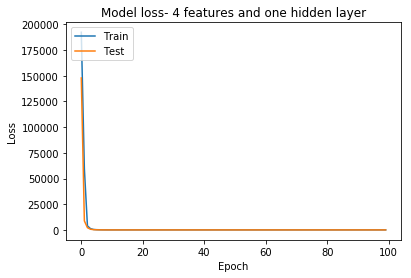

In [35]:
# plotting the loss curve
import matplotlib.pyplot as plt
plt.plot(hist1.history['loss']) 
plt.plot(hist1.history['val_loss']) 
plt.title('Model loss- 4 features and one hidden layer') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [59]:
#Initializing Sequential Graph (model) with 4 variables and two hidden layers
model2 = tf.keras.models.Sequential()
#Normalizing input data
model2.add(tf.keras.layers.BatchNormalization(input_shape=(4,)))
#Adding 1st hidden layer
model2.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
model2.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model2.add(tf.keras.layers.Dense(1, activation = 'linear'))

model2.compile(optimizer='adam', loss='mse')

In [60]:
hist2 = model2.fit(X_train, Y_train,
          batch_size=8, epochs=100,
         validation_data=(X_test, Y_test))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 6s 819us/sample - loss: 132281.9842 - val_loss: 50374.9550
Epoch 2/100
7574/7574 [==============================] - 5s 717us/sample - loss: 16440.2611 - val_loss: 2510.2447
Epoch 3/100
7574/7574 [==============================] - 4s 489us/sample - loss: 622.6497 - val_loss: 187.3756
Epoch 4/100
7574/7574 [==============================] - 4s 549us/sample - loss: 141.2659 - val_loss: 110.1186
Epoch 5/100
7574/7574 [==============================] - 5s 633us/sample - loss: 106.5166 - val_loss: 75.0405
Epoch 6/100
7574/7574 [==============================] - 4s 487us/sample - loss: 87.4416 - val_loss: 54.2331
Epoch 7/100
7574/7574 [==============================] - 5s 612us/sample - loss: 77.1022 - val_loss: 36.9658
Epoch 8/100
7574/7574 [==============================] - 4s 556us/sample - loss: 71.2782 - val_loss: 35.3489
Epoch 9/100
7574/7574 [==============================] - 4s 501

In [61]:
predict_train2 = model2.predict(X_train)
predict_test2 = model2.predict(X_test)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train.PowerOut,predict_train2),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test.PowerOut,predict_test2),3))

r2 of Training data set for neural network:	 0.859
r2 of Testing data set for neural network:	 0.861


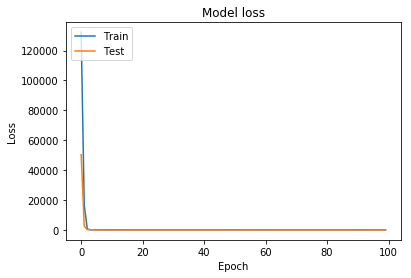

In [62]:
# plotting the loss curve
plt.plot(hist2.history['loss']) 
plt.plot(hist2.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [85]:
#Initializing Sequential Graph (model) with 4 variables and three hidden layers
model3 = tf.keras.models.Sequential()
#Normalizing input data
model3.add(tf.keras.layers.BatchNormalization(input_shape=(4,)))
#Adding 1st hidden layer
model3.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
model3.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
model3.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model3.add(tf.keras.layers.Dense(1, activation = 'linear'))

model3.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [86]:
# Training the model

hist3 = model3.fit(X_train, Y_train,
          batch_size=8, epochs=100,
         validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.cast instead.


Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 5s 680us/sample - loss: 90008.3016 - val_loss: 15959.3941
Epoch 2/100
7574/7574 [==============================] - 3s 450us/sample - loss: 7588.3389 - val_loss: 2722.7723
Epoch 3/100
7574/7574 [==============================] - 4s 581us/sample - loss: 983.7778 - val_loss: 241.3810
Epoch 4/100
7574/7574 [==============================] - 3s 438us/sample - loss: 121.4460 - val_loss: 63.3900
Epoch 5/100
7574/7574 [==============================] - 3s 427us/sample - loss: 78.1862 - val_loss: 30.8771
Epoch 6/100
7574/7574 [==============================] - 4s 543us/sample - loss: 68.4168 - val_loss: 23.6296
Epoch 7/100
7574/7574 [==============================] - 3s 422us/sample - loss: 70.1122 - val_loss: 24.0505
Epoch 8/100
7574/7574 [==============================] - 3s 447us/sample - loss: 70.9046 - val_loss: 62.1479
Epoch 9/100
7574/7574 [==============================] - 4s 547us/s

In [87]:
predict_train3 = model3.predict(X_train)
predict_test3 = model3.predict(X_test)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train.PowerOut,predict_train3),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test.PowerOut,predict_test3),3))

r2 of Training data set for neural network:	 0.89
r2 of Testing data set for neural network:	 0.899


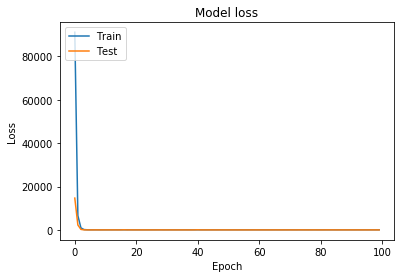

In [56]:
#Plotting the loss curve
plt.plot(hist3.history['loss']) 
plt.plot(hist3.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

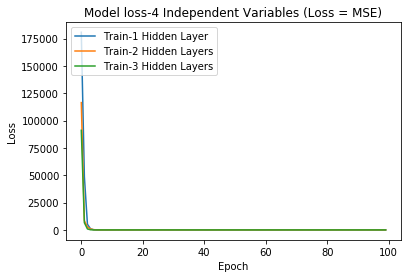

In [95]:
#Plotting the loss curves
plt.plot(hist1.history['loss']) 
plt.plot(hist2.history['loss']) 
#plt.plot(hist2.history['val_loss']) 
plt.plot(hist3.history['loss']) 
#plt.plot(hist3.history['val_loss']) 
plt.title('Model loss-4 Independent Variables (Loss = MSE)') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train-1 Hidden Layer', 'Train-2 Hidden Layers', 'Train-3 Hidden Layers'], loc='upper left') 
plt.show()

## Neural Network Diagnostics: Running the models with different learning rates
  Since learing rate was found to be hight, therefore models will be run with lower learning rates

In [17]:
#Initializing Sequential Graph (model) with 4 variables and one hidden layer and learning rate = 0.1

opt = tf.keras.optimizers.Adam(lr=0.1)
model10 = tf.keras.models.Sequential()
#Normalizing input data
model10.add(tf.keras.layers.BatchNormalization(input_shape=(4,)))
#Adding 1st hidden layer
model10.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
#model.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model10.add(tf.keras.layers.Dense(1, activation = 'linear'))

model10.compile(optimizer=opt, loss='mse')

In [18]:
hist10 = model10.fit(X_train, Y_train,
          batch_size=8, epochs=100,
         validation_data=(X_test, Y_test))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 4s 533us/sample - loss: 4866.3658 - val_loss: 62.6327
Epoch 2/100
7574/7574 [==============================] - 5s 599us/sample - loss: 126.5664 - val_loss: 24.9360
Epoch 3/100
7574/7574 [==============================] - 3s 372us/sample - loss: 151.5221 - val_loss: 42.9116
Epoch 4/100
7574/7574 [==============================] - 3s 351us/sample - loss: 132.0102 - val_loss: 268.5358
Epoch 5/100
7574/7574 [==============================] - 3s 366us/sample - loss: 171.3869 - val_loss: 73.0912
Epoch 6/100
7574/7574 [==============================] - 4s 507us/sample - loss: 144.1540 - val_loss: 284.3235
Epoch 7/100
7574/7574 [==============================] - 3s 376us/sample - loss: 135.9926 - val_loss: 91.2630
Epoch 8/100
7574/7574 [==============================] - 3s 428us/sample - loss: 134.3058 - val_loss: 51.8317
Epoch 9/100
7574/7574 [==============================] - 4s 521us/sam

In [19]:
predict_train10 = model10.predict(X_train)
predict_test10 = model10.predict(X_test)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train.PowerOut,predict_train10),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test.PowerOut,predict_test10),3))

r2 of Training data set for neural network:	 0.897
r2 of Testing data set for neural network:	 0.895


In [23]:
#Initializing Sequential Graph (model) with 4 variables and one hidden layer and learning rate = 0.01

opt = tf.keras.optimizers.Adam(lr=0.01)
model11 = tf.keras.models.Sequential()
#Normalizing input data
model11.add(tf.keras.layers.BatchNormalization(input_shape=(4,)))
#Adding 1st hidden layer
model11.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
#model.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model11.add(tf.keras.layers.Dense(1, activation = 'linear'))

model11.compile(optimizer=opt, loss='mse')

In [24]:
hist11 = model11.fit(X_train, Y_train,
          batch_size=8, epochs=100,
         validation_data=(X_test, Y_test))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 5s 627us/sample - loss: 26768.8686 - val_loss: 136.6230
Epoch 2/100
7574/7574 [==============================] - 3s 385us/sample - loss: 104.9232 - val_loss: 25.3923
Epoch 3/100
7574/7574 [==============================] - 3s 459us/sample - loss: 71.1625 - val_loss: 22.6701
Epoch 4/100
7574/7574 [==============================] - 4s 515us/sample - loss: 72.2862 - val_loss: 40.1360
Epoch 5/100
7574/7574 [==============================] - 3s 364us/sample - loss: 80.8274 - val_loss: 30.2424
Epoch 6/100
7574/7574 [==============================] - 3s 397us/sample - loss: 73.8839 - val_loss: 25.2078
Epoch 7/100
7574/7574 [==============================] - 4s 561us/sample - loss: 81.5363 - val_loss: 28.2000
Epoch 8/100
7574/7574 [==============================] - 3s 371us/sample - loss: 81.0913 - val_loss: 26.7115
Epoch 9/100
7574/7574 [==============================] - 3s 374us/sample - 

In [25]:
predict_train11 = model11.predict(X_train)
predict_test11 = model11.predict(X_test)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train.PowerOut,predict_train11),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test.PowerOut,predict_test11),3))

r2 of Training data set for neural network:	 0.909
r2 of Testing data set for neural network:	 0.909


In [27]:
#Initializing Sequential Graph (model) with 4 variables and one hidden layer and learning rate = 0.0001

opt = tf.keras.optimizers.Adam(lr=0.0001)
model12 = tf.keras.models.Sequential()
#Normalizing input data
model12.add(tf.keras.layers.BatchNormalization(input_shape=(4,)))
#Adding 1st hidden layer
model12.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
#model.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model12.add(tf.keras.layers.Dense(1, activation = 'linear'))

model12.compile(optimizer=opt, loss='mse')

In [28]:
hist12 = model12.fit(X_train, Y_train,
          batch_size=8, epochs=200,
         validation_data=(X_test, Y_test))

Train on 7574 samples, validate on 1894 samples
Epoch 1/200
7574/7574 [==============================] - 4s 589us/sample - loss: 205999.6620 - val_loss: 205378.1758
Epoch 2/200
7574/7574 [==============================] - 3s 394us/sample - loss: 204957.3898 - val_loss: 203979.8983
Epoch 3/200
7574/7574 [==============================] - 4s 525us/sample - loss: 203322.7296 - val_loss: 201807.0521
Epoch 4/200
7574/7574 [==============================] - 3s 386us/sample - loss: 200950.3298 - val_loss: 198946.9457
Epoch 5/200
7574/7574 [==============================] - 3s 459us/sample - loss: 197728.3601 - val_loss: 195066.6561
Epoch 6/200
7574/7574 [==============================] - 4s 520us/sample - loss: 193625.3402 - val_loss: 190283.3522
Epoch 7/200
7574/7574 [==============================] - 3s 391us/sample - loss: 188545.6663 - val_loss: 184333.3814
Epoch 8/200
7574/7574 [==============================] - 3s 384us/sample - loss: 182598.5073 - val_loss: 177560.0595
Epoch 9/200
7574

In [29]:
predict_train12 = model12.predict(X_train)
predict_test12 = model12.predict(X_test)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train.PowerOut,predict_train12),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test.PowerOut,predict_test12),3))

r2 of Training data set for neural network:	 0.92
r2 of Testing data set for neural network:	 0.92


In [31]:
#Initializing Sequential Graph (model) with 4 variables and one hidden layer and learning rate = 0.00001

opt = tf.keras.optimizers.Adam(lr=0.00001)
model13 = tf.keras.models.Sequential()
#Normalizing input data
model13.add(tf.keras.layers.BatchNormalization(input_shape=(4,)))
#Adding 1st hidden layer
model13.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
#model.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model13.add(tf.keras.layers.Dense(1, activation = 'linear'))

model13.compile(optimizer=opt, loss='mse')

In [32]:
hist13 = model13.fit(X_train, Y_train,
          batch_size=8, epochs=200,
         validation_data=(X_test, Y_test))

Train on 7574 samples, validate on 1894 samples
Epoch 1/200
7574/7574 [==============================] - 6s 743us/sample - loss: 206505.0187 - val_loss: 206335.0276
Epoch 2/200
7574/7574 [==============================] - 3s 382us/sample - loss: 206413.2485 - val_loss: 206214.8695
Epoch 3/200
7574/7574 [==============================] - 3s 398us/sample - loss: 206321.6773 - val_loss: 206123.3709
Epoch 4/200
7574/7574 [==============================] - 4s 556us/sample - loss: 206228.4099 - val_loss: 206027.6934
Epoch 5/200
7574/7574 [==============================] - 3s 386us/sample - loss: 206132.6234 - val_loss: 205916.0658
Epoch 6/200
7574/7574 [==============================] - 3s 415us/sample - loss: 206034.7826 - val_loss: 205817.8890
Epoch 7/200
7574/7574 [==============================] - 5s 598us/sample - loss: 205934.1087 - val_loss: 205713.2196
Epoch 8/200
7574/7574 [==============================] - 3s 400us/sample - loss: 205833.3332 - val_loss: 205629.6989
Epoch 9/200
7574

In [37]:
predict_train13 = model13.predict(X_train)
predict_test13 = model13.predict(X_test)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train.PowerOut,predict_train13),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test.PowerOut,predict_test13),3))

r2 of Training data set for neural network:	 -367.897
r2 of Testing data set for neural network:	 -354.571


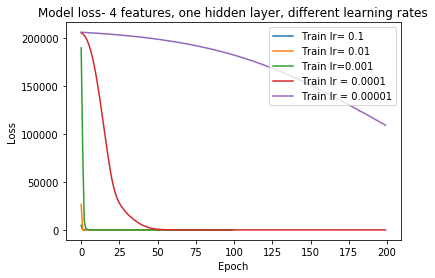

In [38]:
#Plotting the loss curve
import matplotlib.pyplot as plt
plt.plot(hist10.history['loss']) 
plt.plot(hist11.history['loss']) 
plt.plot(hist1.history['loss']) 
plt.plot(hist12.history['loss'])
plt.plot(hist13.history['loss'])
plt.title('Model loss- 4 features, one hidden layer, different learning rates') 
plt.ylabel('Loss')  
plt.xlabel('Epoch') 
plt.legend(['Train lr= 0.1', 'Train lr= 0.01', 'Train lr=0.001', 'Train lr = 0.0001', 'Train lr = 0.00001'], loc='upper right') 
plt.show()

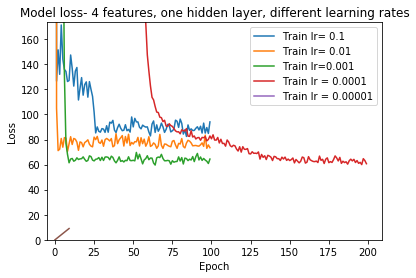

In [50]:
import matplotlib.pyplot as plt
plt.plot(hist10.history['loss']) 
plt.plot(hist11.history['loss']) 
plt.plot(hist1.history['loss']) 
plt.plot(hist12.history['loss'])
plt.plot(hist13.history['loss'])
plt.title('Model loss- 4 features, one hidden layer, different learning rates') 
plt.ylabel('Loss')  
plt.xlabel('Epoch') 
plt.legend(['Train lr= 0.1', 'Train lr= 0.01', 'Train lr=0.001', 'Train lr = 0.0001', 'Train lr = 0.00001'], loc='upper right') 
plt.plot(range(0, 10))
#Initial axes limits are 0, 10
#scale_factor = 0.5

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.xlim(xmin * scale_factor, xmax)
plt.ylim(ymin * 0, ymax * 0.0008)
plt.show()

## Investigation of learning rate with different number of hidden layres

In [52]:
#Initializing Sequential Graph (model) with 4 variables and two hidden layers and learning rate = 0.0001

opt = tf.keras.optimizers.Adam(lr=0.0001)
model14 = tf.keras.models.Sequential()
#Normalizing input data
model14.add(tf.keras.layers.BatchNormalization(input_shape=(4,)))
#Adding 1st hidden layer
model14.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
model14.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model14.add(tf.keras.layers.Dense(1, activation = 'linear'))

model14.compile(optimizer=opt, loss='mse')

In [53]:
hist14 = model14.fit(X_train, Y_train,
          batch_size=8, epochs=200,
         validation_data=(X_test, Y_test))

Train on 7574 samples, validate on 1894 samples
Epoch 1/200
7574/7574 [==============================] - 6s 848us/sample - loss: 206201.8150 - val_loss: 205398.8095
Epoch 2/200
7574/7574 [==============================] - 4s 471us/sample - loss: 204284.8082 - val_loss: 202382.0276
Epoch 3/200
7574/7574 [==============================] - 4s 561us/sample - loss: 199907.7182 - val_loss: 195932.0820
Epoch 4/200
7574/7574 [==============================] - 5s 620us/sample - loss: 191136.6523 - val_loss: 183442.8388
Epoch 5/200
7574/7574 [==============================] - 4s 475us/sample - loss: 175633.6469 - val_loss: 163559.3398
Epoch 6/200
7574/7574 [==============================] - 4s 535us/sample - loss: 153875.8862 - val_loss: 139462.2336
Epoch 7/200
7574/7574 [==============================] - 5s 610us/sample - loss: 128736.1107 - val_loss: 113483.6297
Epoch 8/200
7574/7574 [==============================] - 4s 467us/sample - loss: 106023.3249 - val_loss: 93656.5769
Epoch 9/200
7574/

In [54]:
predict_train14 = model14.predict(X_train)
predict_test14 = model14.predict(X_test)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train.PowerOut,predict_train14),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test.PowerOut,predict_test14),3))

r2 of Training data set for neural network:	 0.926
r2 of Testing data set for neural network:	 0.927


In [55]:
#Initializing Sequential Graph (model) with 4 variables and three hidden layers and learning rate = 0.0001

opt = tf.keras.optimizers.Adam(lr=0.0001)
model15 = tf.keras.models.Sequential()
#Normalizing input data
model15.add(tf.keras.layers.BatchNormalization(input_shape=(4,)))
#Adding 1st hidden layer
model15.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
model15.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
model15.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model15.add(tf.keras.layers.Dense(1, activation = 'linear'))

model15.compile(optimizer=opt, loss='mse')

In [56]:
hist15 = model15.fit(X_train, Y_train,
          batch_size=8, epochs=200,
         validation_data=(X_test, Y_test))

Train on 7574 samples, validate on 1894 samples
Epoch 1/200
7574/7574 [==============================] - 7s 883us/sample - loss: 205456.4253 - val_loss: 203537.2160
Epoch 2/200
7574/7574 [==============================] - 4s 556us/sample - loss: 199973.5622 - val_loss: 193435.2697
Epoch 3/200
7574/7574 [==============================] - 5s 704us/sample - loss: 182737.0146 - val_loss: 164979.5057
Epoch 4/200
7574/7574 [==============================] - 5s 655us/sample - loss: 145125.0200 - val_loss: 114349.1010
Epoch 5/200
7574/7574 [==============================] - 6s 750us/sample - loss: 91900.9983 - val_loss: 59561.9642
Epoch 6/200
7574/7574 [==============================] - 5s 658us/sample - loss: 49001.4618 - val_loss: 33634.6320
Epoch 7/200
7574/7574 [==============================] - 6s 745us/sample - loss: 31726.4556 - val_loss: 27310.7611
Epoch 8/200
7574/7574 [==============================] - 5s 630us/sample - loss: 26682.9236 - val_loss: 23894.0443
Epoch 9/200
7574/7574 [=

In [57]:
predict_train15 = model15.predict(X_train)
predict_test15 = model15.predict(X_test)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train.PowerOut,predict_train15),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test.PowerOut,predict_test15),3))

r2 of Training data set for neural network:	 0.929
r2 of Testing data set for neural network:	 0.929


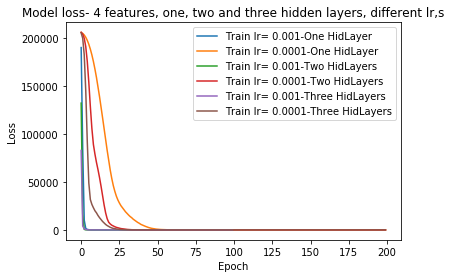

In [66]:
import matplotlib.pyplot as plt
plt.plot(hist1.history['loss'])
plt.plot(hist12.history['loss'])
plt.plot(hist2.history['loss'])
plt.plot(hist14.history['loss'])
plt.plot(hist3.history['loss'])
plt.plot(hist15.history['loss'])
plt.title('Model loss- 4 features, one, two and three hidden layers, different lr,s') 
plt.ylabel('Loss')  
plt.xlabel('Epoch') 
plt.legend(['Train lr= 0.001-One HidLayer', 'Train lr= 0.0001-One HidLayer', 'Train lr= 0.001-Two HidLayers', 'Train lr= 0.0001-Two HidLayers', 'Train lr= 0.001-Three HidLayers', 'Train lr= 0.0001-Three HidLayers'], loc='upper right') 
plt.show()

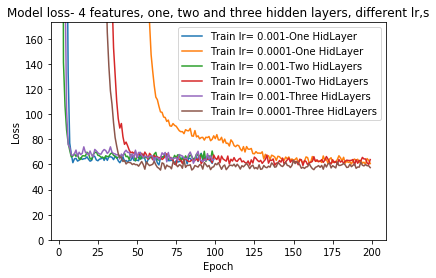

In [67]:
import matplotlib.pyplot as plt
plt.plot(hist1.history['loss'])
plt.plot(hist12.history['loss'])
plt.plot(hist2.history['loss'])
plt.plot(hist14.history['loss'])
plt.plot(hist3.history['loss'])
plt.plot(hist15.history['loss'])
plt.title('Model loss- 4 features, one, two and three hidden layers, different lr,s') 
plt.ylabel('Loss')  
plt.xlabel('Epoch') 
plt.legend(['Train lr= 0.001-One HidLayer', 'Train lr= 0.0001-One HidLayer', 'Train lr= 0.001-Two HidLayers', 'Train lr= 0.0001-Two HidLayers', 'Train lr= 0.001-Three HidLayers', 'Train lr= 0.0001-Three HidLayers'], loc='upper right') 

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.xlim(xmin * scale_factor, xmax)
plt.ylim(ymin * 0, ymax * 0.0008)
plt.show()

### Neural network models with only two parameters as input features
Since ambient temperature and exhaust vacuum have stronger linear correlation with power output, therefore model is created with only these two parameters

In [21]:
# Defining the traning and test data sets for neural network with only Ambient temperature and Exhaust vacuum
X_train1 = train[["AtmTemperature", "ExhaustV"]]
Y_train1 = train[["PowerOut"]]
X_test1 = test[["AtmTemperature", "ExhaustV"]]
Y_test1 = test[["PowerOut"]]
print("Size of X Train1:\t",X_train1.count())
print("Size of X Test1:\t",X_test1.count())

Size of X Train1:	 AtmTemperature    7574
ExhaustV          7574
dtype: int64
Size of X Test1:	 AtmTemperature    1894
ExhaustV          1894
dtype: int64


In [23]:
#Initializing Sequential Graph (model) for 2 variables with only one hidden layer
model = tf.keras.models.Sequential()
#Normalizing input data
model.add(tf.keras.layers.BatchNormalization(input_shape=(2,)))
#Adding 1st hidden layer
model.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
#model.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model.add(tf.keras.layers.Dense(1, activation = 'linear'))
model.compile(optimizer='adam', loss='mse')

In [24]:
hist = model.fit(X_train1, Y_train1,
          batch_size=8, epochs=100,
         validation_data=(X_test1, Y_test1))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 4s 544us/sample - loss: 186874.9848 - val_loss: 140283.6528
Epoch 2/100
7574/7574 [==============================] - 3s 347us/sample - loss: 93270.2753 - val_loss: 66498.1160
Epoch 3/100
7574/7574 [==============================] - 3s 366us/sample - loss: 34358.4083 - val_loss: 13112.6387
Epoch 4/100
7574/7574 [==============================] - 3s 433us/sample - loss: 5410.6301 - val_loss: 1775.4080
Epoch 5/100
7574/7574 [==============================] - 3s 371us/sample - loss: 627.6202 - val_loss: 142.2866
Epoch 6/100
7574/7574 [==============================] - 3s 356us/sample - loss: 110.3866 - val_loss: 49.5800
Epoch 7/100
7574/7574 [==============================] - 3s 358us/sample - loss: 78.8634 - val_loss: 38.9588
Epoch 8/100
7574/7574 [==============================] - 4s 463us/sample - loss: 75.2403 - val_loss: 31.3856
Epoch 9/100
7574/7574 [==============================

In [25]:
predict_train = model.predict(X_train1)
predict_test = model.predict(X_test1)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train1.PowerOut,predict_train),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test1.PowerOut,predict_test),3))

r2 of Training data set for neural network:	 0.913
r2 of Testing data set for neural network:	 0.914


In [26]:
#Initializing Sequential Graph (model) for 2 variables with two hidden layers
model = tf.keras.models.Sequential()
#Normalizing input data
model.add(tf.keras.layers.BatchNormalization(input_shape=(2,)))
#Adding 1st hidden layer
model.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
model.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model.add(tf.keras.layers.Dense(1, activation = 'linear'))
model.compile(optimizer='adam', loss='mse')

In [27]:
hist = model.fit(X_train1, Y_train1,
          batch_size=8, epochs=100,
         validation_data=(X_test1, Y_test1))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 5s 637us/sample - loss: 141557.2840 - val_loss: 29880.9148
Epoch 2/100
7574/7574 [==============================] - 3s 442us/sample - loss: 29591.8328 - val_loss: 17199.5718
Epoch 3/100
7574/7574 [==============================] - 4s 520us/sample - loss: 14268.4866 - val_loss: 5202.7051
Epoch 4/100
7574/7574 [==============================] - 3s 445us/sample - loss: 3354.5861 - val_loss: 1190.0841
Epoch 5/100
7574/7574 [==============================] - 3s 458us/sample - loss: 851.4496 - val_loss: 397.9778
Epoch 6/100
7574/7574 [==============================] - 4s 539us/sample - loss: 273.8483 - val_loss: 106.7945
Epoch 7/100
7574/7574 [==============================] - 3s 431us/sample - loss: 109.3990 - val_loss: 45.5058
Epoch 8/100
7574/7574 [==============================] - 3s 434us/sample - loss: 75.7780 - val_loss: 30.1156
Epoch 9/100
7574/7574 [==============================

In [28]:
predict_train = model.predict(X_train1)
predict_test = model.predict(X_test1)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train1.PowerOut,predict_train),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test1.PowerOut,predict_test),3))

r2 of Training data set for neural network:	 0.92
r2 of Testing data set for neural network:	 0.921


In [30]:
#Initializing Sequential Graph (model) for 2 variables with three hidden layers
model = tf.keras.models.Sequential()
#Normalizing input data
model.add(tf.keras.layers.BatchNormalization(input_shape=(2,)))
#Adding 1st hidden layer
model.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
model.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model.add(tf.keras.layers.Dense(1, activation = 'linear'))
model.compile(optimizer='adam', loss='mse')

In [31]:
hist = model.fit(X_train1, Y_train1,
          batch_size=8, epochs=100,
         validation_data=(X_test1, Y_test1))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 6s 766us/sample - loss: 89722.8013 - val_loss: 8012.0554
Epoch 2/100
7574/7574 [==============================] - 5s 619us/sample - loss: 5525.6224 - val_loss: 2859.8878
Epoch 3/100
7574/7574 [==============================] - 4s 530us/sample - loss: 1799.1823 - val_loss: 1009.2315
Epoch 4/100
7574/7574 [==============================] - 5s 602us/sample - loss: 671.9279 - val_loss: 368.5608
Epoch 5/100
7574/7574 [==============================] - 4s 541us/sample - loss: 259.2188 - val_loss: 149.5531
Epoch 6/100
7574/7574 [==============================] - 4s 535us/sample - loss: 120.4399 - val_loss: 67.3138
Epoch 7/100
7574/7574 [==============================] - 5s 632us/sample - loss: 82.4105 - val_loss: 37.2476
Epoch 8/100
7574/7574 [==============================] - 4s 536us/sample - loss: 74.9430 - val_loss: 30.6452
Epoch 9/100
7574/7574 [==============================] - 4s 52

In [32]:
predict_train = model.predict(X_train1)
predict_test = model.predict(X_test1)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train1.PowerOut,predict_train),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test1.PowerOut,predict_test),3))

r2 of Training data set for neural network:	 0.854
r2 of Testing data set for neural network:	 0.857


### Neural network models with only three parameters as input features

In [63]:
# Defining the traning and test data sets for neural network
X_train2 = train[["AtmTemperature", "ExhaustV", "AtmPressure"]]
Y_train2 = train[["PowerOut"]]
X_test2 = test[["AtmTemperature", "ExhaustV", "AtmPressure"]]
Y_test2 = test[["PowerOut"]]
print("Size of X Train:\t",X_train2.count())
print("Size of X Test:\t",X_test2.count())

Size of X Train:	 AtmTemperature    7574
ExhaustV          7574
AtmPressure       7574
dtype: int64
Size of X Test:	 AtmTemperature    1894
ExhaustV          1894
AtmPressure       1894
dtype: int64


In [64]:
#Initializing Sequential Graph (model) for 3 variables and 1 hidden layer
model4 = tf.keras.models.Sequential()
#Normalizing input data
model4.add(tf.keras.layers.BatchNormalization(input_shape=(3,)))
#Adding 1st hidden layer
model4.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
#model.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model4.add(tf.keras.layers.Dense(1, activation='linear'))
model4.compile(optimizer='adam', loss='mse')

In [65]:
hist4 = model4.fit(X_train2, Y_train2,
          batch_size=8, epochs=100,
         validation_data=(X_test2, Y_test2))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 5s 663us/sample - loss: 187723.9124 - val_loss: 144408.3244
Epoch 2/100
7574/7574 [==============================] - 4s 513us/sample - loss: 90092.2167 - val_loss: 42566.3351
Epoch 3/100
7574/7574 [==============================] - 3s 392us/sample - loss: 16052.4531 - val_loss: 4894.1962
Epoch 4/100
7574/7574 [==============================] - 3s 414us/sample - loss: 1790.8067 - val_loss: 630.8936
Epoch 5/100
7574/7574 [==============================] - 4s 490us/sample - loss: 303.5359 - val_loss: 150.9883
Epoch 6/100
7574/7574 [==============================] - 3s 393us/sample - loss: 123.9532 - val_loss: 71.3287
Epoch 7/100
7574/7574 [==============================] - 3s 402us/sample - loss: 92.3258 - val_loss: 50.2835
Epoch 8/100
7574/7574 [==============================] - 3s 412us/sample - loss: 77.0786 - val_loss: 36.7838
Epoch 9/100
7574/7574 [==============================] 

In [66]:
predict_train4 = model4.predict(X_train2)
predict_test4 = model4.predict(X_test2)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train2.PowerOut,predict_train4),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test2.PowerOut,predict_test4),3))

r2 of Training data set for neural network:	 0.913
r2 of Testing data set for neural network:	 0.913


In [67]:
#Initializing Sequential Graph (model) for 3 variables and 2 hidden layers
model5 = tf.keras.models.Sequential()
#Normalizing input data
model5.add(tf.keras.layers.BatchNormalization(input_shape=(3,)))
#Adding 1st hidden layer
model5.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
model5.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model5.add(tf.keras.layers.Dense(1, activation='linear'))
model5.compile(optimizer='adam', loss='mse')

In [68]:
hist5 = model5.fit(X_train2, Y_train2,
          batch_size=8, epochs=100,
         validation_data=(X_test2, Y_test2))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 6s 792us/sample - loss: 119936.1438 - val_loss: 19965.4764
Epoch 2/100
7574/7574 [==============================] - 5s 596us/sample - loss: 10189.8131 - val_loss: 6242.6378
Epoch 3/100
7574/7574 [==============================] - 4s 511us/sample - loss: 3405.0497 - val_loss: 2120.8939
Epoch 4/100
7574/7574 [==============================] - 4s 579us/sample - loss: 1215.8907 - val_loss: 763.1740
Epoch 5/100
7574/7574 [==============================] - 4s 470us/sample - loss: 436.8629 - val_loss: 246.2236
Epoch 6/100
7574/7574 [==============================] - 4s 485us/sample - loss: 185.2015 - val_loss: 87.4213
Epoch 7/100
7574/7574 [==============================] - 5s 615us/sample - loss: 101.5744 - val_loss: 42.3236
Epoch 8/100
7574/7574 [==============================] - 4s 484us/sample - loss: 76.3470 - val_loss: 29.1534
Epoch 9/100
7574/7574 [==============================] - 

In [69]:
predict_train5 = model5.predict(X_train2)
predict_test5 = model5.predict(X_test2)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train2.PowerOut,predict_train5),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test2.PowerOut,predict_test5),3))

r2 of Training data set for neural network:	 0.91
r2 of Testing data set for neural network:	 0.91


In [70]:
#Initializing Sequential Graph (model) for 3 variables and 3 hidden layers
model6 = tf.keras.models.Sequential()
#Normalizing input data
model6.add(tf.keras.layers.BatchNormalization(input_shape=(3,)))
#Adding 1st hidden layer
model6.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
model6.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
model6.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model6.add(tf.keras.layers.Dense(1, activation='linear'))
model6.compile(optimizer='adam', loss='mse')

In [71]:
hist6 = model6.fit(X_train2, Y_train2,
          batch_size=8, epochs=100,
         validation_data=(X_test2, Y_test2))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 7s 926us/sample - loss: 97085.7133 - val_loss: 20044.0217
Epoch 2/100
7574/7574 [==============================] - 5s 680us/sample - loss: 10913.6910 - val_loss: 3691.5526
Epoch 3/100
7574/7574 [==============================] - 5s 604us/sample - loss: 1654.3567 - val_loss: 452.6700
Epoch 4/100
7574/7574 [==============================] - 5s 685us/sample - loss: 237.3950 - val_loss: 61.1268
Epoch 5/100
7574/7574 [==============================] - 4s 571us/sample - loss: 91.4575 - val_loss: 35.7031
Epoch 6/100
7574/7574 [==============================] - 5s 678us/sample - loss: 76.1878 - val_loss: 28.8482
Epoch 7/100
7574/7574 [==============================] - 4s 575us/sample - loss: 70.7339 - val_loss: 26.5772
Epoch 8/100
7574/7574 [==============================] - 5s 595us/sample - loss: 62.5239 - val_loss: 25.1523
Epoch 9/100
7574/7574 [==============================] - 5s 693us

In [72]:
predict_train6 = model6.predict(X_train2)
predict_test6 = model6.predict(X_test2)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train2.PowerOut,predict_train6),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test2.PowerOut,predict_test6),3))

r2 of Training data set for neural network:	 0.916
r2 of Testing data set for neural network:	 0.915


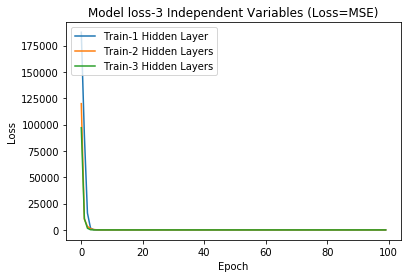

In [94]:
plt.plot(hist4.history['loss']) 
plt.plot(hist5.history['loss']) 
#plt.plot(hist2.history['val_loss']) 
plt.plot(hist6.history['loss']) 
#plt.plot(hist3.history['val_loss']) 
plt.title('Model loss-3 Independent Variables (Loss=MSE)') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train-1 Hidden Layer', 'Train-2 Hidden Layers', 'Train-3 Hidden Layers'], loc='upper left') 
plt.show()

### Investing different loss function for dataset with 2 variables

In [76]:
#Initializing Sequential Graph (model) for 3 variables and 1 hidden layer
model7 = tf.keras.models.Sequential()
#Normalizing input data
model7.add(tf.keras.layers.BatchNormalization(input_shape=(3,)))
#Adding 1st hidden layer
model7.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
#model.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model7.add(tf.keras.layers.Dense(1, activation='linear'))
model7.compile(optimizer='adam', loss='mean_absolute_percentage_error')

In [77]:
hist7 = model7.fit(X_train2, Y_train2,
          batch_size=8, epochs=100,
         validation_data=(X_test2, Y_test2))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 6s 753us/sample - loss: 95.8006 - val_loss: 86.0705
Epoch 2/100
7574/7574 [==============================] - 4s 580us/sample - loss: 63.6986 - val_loss: 45.8743
Epoch 3/100
7574/7574 [==============================] - 3s 429us/sample - loss: 33.1787 - val_loss: 17.6794
Epoch 4/100
7574/7574 [==============================] - 3s 437us/sample - loss: 13.4731 - val_loss: 10.7637
Epoch 5/100
7574/7574 [==============================] - 4s 532us/sample - loss: 8.9017 - val_loss: 6.6065
Epoch 6/100
7574/7574 [==============================] - 3s 428us/sample - loss: 5.7030 - val_loss: 4.2365
Epoch 7/100
7574/7574 [==============================] - 3s 451us/sample - loss: 3.8557 - val_loss: 2.7972
Epoch 8/100
7574/7574 [==============================] - 4s 524us/sample - loss: 2.6846 - val_loss: 1.8419
Epoch 9/100
7574/7574 [==============================] - 3s 434us/sample - loss: 2.0296 

In [78]:
predict_train7 = model7.predict(X_train2)
predict_test7 = model7.predict(X_test2)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train2.PowerOut,predict_train7),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test2.PowerOut,predict_test7),3))

r2 of Training data set for neural network:	 0.914
r2 of Testing data set for neural network:	 0.914


In [79]:
#Initializing Sequential Graph (model) for 3 variables and 2 hidden layers
model8 = tf.keras.models.Sequential()
#Normalizing input data
model8.add(tf.keras.layers.BatchNormalization(input_shape=(3,)))
#Adding 1st hidden layer
model8.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
model8.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
#model.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model8.add(tf.keras.layers.Dense(1, activation='linear'))
model8.compile(optimizer='adam', loss='mean_absolute_percentage_error')

In [80]:
hist8 = model8.fit(X_train2, Y_train2,
          batch_size=8, epochs=100,
         validation_data=(X_test2, Y_test2))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 7s 892us/sample - loss: 72.6355 - val_loss: 43.9900
Epoch 2/100
7574/7574 [==============================] - 5s 638us/sample - loss: 25.5910 - val_loss: 8.5848
Epoch 3/100
7574/7574 [==============================] - 4s 522us/sample - loss: 2.8747 - val_loss: 1.1736
Epoch 4/100
7574/7574 [==============================] - 4s 516us/sample - loss: 1.5035 - val_loss: 1.0479
Epoch 5/100
7574/7574 [==============================] - 5s 644us/sample - loss: 1.4267 - val_loss: 1.0026
Epoch 6/100
7574/7574 [==============================] - 4s 517us/sample - loss: 1.4432 - val_loss: 0.9347
Epoch 7/100
7574/7574 [==============================] - 5s 605us/sample - loss: 1.4006 - val_loss: 1.0844
Epoch 8/100
7574/7574 [==============================] - 4s 533us/sample - loss: 1.3804 - val_loss: 0.8832
Epoch 9/100
7574/7574 [==============================] - 4s 516us/sample - loss: 1.3775 - val

In [81]:
predict_train8 = model8.predict(X_train2)
predict_test8 = model8.predict(X_test2)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train2.PowerOut,predict_train8),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test2.PowerOut,predict_test8),3))

r2 of Training data set for neural network:	 0.916
r2 of Testing data set for neural network:	 0.913


In [82]:
#Initializing Sequential Graph (model) for 3 variables and 3 hidden layers
model9 = tf.keras.models.Sequential()
#Normalizing input data
model9.add(tf.keras.layers.BatchNormalization(input_shape=(3,)))
#Adding 1st hidden layer
model9.add(tf.keras.layers.Dense(8, activation='relu'))
#Adding 2nd hidden layer
model9.add(tf.keras.layers.Dense(6, activation='relu'))
#Adding 3rd hidden layer
model9.add(tf.keras.layers.Dense(4, activation='relu'))
#Adding Dense layer for prediction - Keras declares weights and bias automatically
model9.add(tf.keras.layers.Dense(1, activation='linear'))
model9.compile(optimizer='adam', loss='mean_absolute_percentage_error')

In [83]:
hist9 = model9.fit(X_train2, Y_train2,
          batch_size=8, epochs=100,
         validation_data=(X_test2, Y_test2))

Train on 7574 samples, validate on 1894 samples
Epoch 1/100
7574/7574 [==============================] - 7s 987us/sample - loss: 62.1810 - val_loss: 15.5280
Epoch 2/100
7574/7574 [==============================] - 5s 698us/sample - loss: 11.9607 - val_loss: 8.2174
Epoch 3/100
7574/7574 [==============================] - 5s 603us/sample - loss: 6.1371 - val_loss: 4.3542
Epoch 4/100
7574/7574 [==============================] - 5s 708us/sample - loss: 2.8721 - val_loss: 1.9308
Epoch 5/100
7574/7574 [==============================] - 5s 623us/sample - loss: 1.5520 - val_loss: 1.1739
Epoch 6/100
7574/7574 [==============================] - 5s 675us/sample - loss: 1.4444 - val_loss: 0.9459
Epoch 7/100
7574/7574 [==============================] - 5s 642us/sample - loss: 1.4371 - val_loss: 0.8866
Epoch 8/100
7574/7574 [==============================] - 5s 619us/sample - loss: 1.4313 - val_loss: 0.8919
Epoch 9/100
7574/7574 [==============================] - 5s 703us/sample - loss: 1.4248 - val

In [84]:
predict_train9 = model9.predict(X_train2)
predict_test9 = model9.predict(X_test2)
from sklearn import metrics
# Determing Accuracy/r2 of Training and Testing data set
print("r2 of Training data set for neural network:\t",round(metrics.r2_score(Y_train2.PowerOut,predict_train9),3))
print("r2 of Testing data set for neural network:\t",round(metrics.r2_score(Y_test2.PowerOut,predict_test9),3))

r2 of Training data set for neural network:	 0.884
r2 of Testing data set for neural network:	 0.887


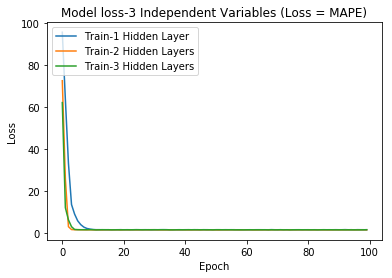

In [93]:
plt.plot(hist7.history['loss']) 
plt.plot(hist8.history['loss']) 
plt.plot(hist9.history['loss']) 
plt.title('Model loss-3 Independent Variables (Loss = MAPE)') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train-1 Hidden Layer', 'Train-2 Hidden Layers', 'Train-3 Hidden Layers'], loc='upper left') 
plt.show()